In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, recall_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import RandomUnderSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [ ]:
from dataloader_creator import CreatorDL
creator = CreatorDL(seed=42, bs=2048)

In [ ]:
df_UNSW = creator.reader("NF-UNSW-NB15-v3")

df_train_UNSW, df_test_UNSW, df_val_UNSW = creator.splitter(df_UNSW)

train_loader_UNSW, test_loader_UNSW, val_loader_UNSW = creator.balancer(df_train_UNSW, df_test_UNSW, df_val_UNSW)

In [ ]:
df_BOT = creator.reader("NF-BoT-IoT-v3")

df_train_BOT, df_test_BOT, df_val_BOT = creator.splitter(df_BOT)

train_loader_BOT, test_loader_BOT, val_loader_BOT = creator.balancer(df_train_BOT, df_test_BOT, df_val_BOT)

In [ ]:
df_CIC = creator.reader("NF-CICIDS2018-v3")

df_train_CIC, df_test_CIC, df_val_CIC = creator.splitter(df_CIC)

train_loader_CIC, test_loader_CIC, val_loader_CIC = creator.balancer(df_train_CIC, df_test_CIC, df_val_CIC)

In [ ]:
model_names = ['UNSW_EA', 'BOT_EA', 'CIC_EA']
test_ids = [1, 2, 3]
train_loaders = [train_loader_UNSW, train_loader_BOT, train_loader_CIC]
test_loaders = [test_loader_UNSW, test_loader_BOT, test_loader_CIC]
val_loaders = [val_loader_UNSW, val_loader_BOT, val_loader_CIC]

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

In [ ]:
INPUT_DIM = 32

class IDSBranchyNet(nn.Module):
    def __init__(self, input_dim=INPUT_DIM, num_classes=2):
        super(IDSBranchyNet, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(input_dim * 2, input_dim * 2),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        
        self.exit1_layers = nn.Sequential(
            nn.Linear(input_dim * 2, num_classes)
        )
        
        self.exit2_layers = nn.Sequential(
            nn.Linear(input_dim * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, num_classes)
        )

    def forward_exit1(self, x):
        features = self.shared_layers(x)
        return self.exit1_layers(features)

    def forward_exit2(self, x):
        features = self.shared_layers(x)
        return self.exit2_layers(features)

model = IDSBranchyNet()

In [ ]:
def train_model(model, train_loader, val_loader, epochs, weight1, weight2, lr, device, modelname, patience=15):
    model.to(device)
    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.001, patience=7)

    train_loss_history = []
    val_loss_history = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs1 = model.forward_exit1(inputs)
            loss1 = criterion(outputs1, labels)
            
            outputs2 = model.forward_exit2(inputs)
            loss2 = criterion(outputs2, labels)
                
            total_loss = (weight1 * loss1) + (weight2 * loss2)

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            running_train_loss += total_loss.item()
        
        epoch_train_loss = running_train_loss / len(train_loader)
        train_loss_history.append(epoch_train_loss)

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs1 = model.forward_exit1(inputs)
                loss1 = criterion(outputs1, labels)
                
                outputs2 = model.forward_exit2(inputs)
                loss2 = criterion(outputs2, labels)
                    
                total_loss = (weight1 * loss1) + (weight2 * loss2)
                
                val_loss += total_loss.item()
        
        epoch_val_loss = val_loss/len(val_loader)
        val_loss_history.append(epoch_val_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_train_loss:.4f}, Validation Loss: {epoch_val_loss:.4f}')
        
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f'\n--- EARLY STOPPING ATIVADO ---')
            print(f'Parando o treino na época {epoch+1} pois a loss de validação não melhora há {patience} épocas.')
            print(f'A melhor loss de validação foi: {best_val_loss:.4f}')
            if best_model_state:
                model.load_state_dict(best_model_state)
            break
            
        scheduler.step(epoch_val_loss) 

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Loss de Treinamento')
    plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Loss de Validação')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Curvas de Loss de Treinamento e Validação')
    plt.legend()
    plt.grid(True)
    plt.show()

    return train_loss_history, val_loss_history

In [15]:
def evaluate_model(model, loader, confidence_threshold, device):
    model.to(device)
    model.eval()

    total_samples = len(loader.dataset)
    all_predictions = []
    all_labels = []
    exited_early_count = 0
    
    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    start_time = time.perf_counter()

    with torch.no_grad():
        for samples, labels in loader:
            samples, labels = samples.to(device), labels.to(device)

            branch_output = model.forward_exit1(samples)
            
            branch_prob = F.softmax(branch_output, dim=1)
            branch_conf, branch_preds = torch.max(branch_prob, 1)

            batch_predictions = torch.zeros_like(labels)
            
            early_exit_mask = branch_conf > confidence_threshold
            
            if early_exit_mask.any():
                batch_predictions[early_exit_mask] = branch_preds[early_exit_mask]
                exited_early_count += early_exit_mask.sum().item()

            main_branch_mask = ~early_exit_mask
            if main_branch_mask.any():
                
                samples_to_main = samples[main_branch_mask]
                
                main_output = model.forward_exit2(samples_to_main)
                
                main_prob = F.softmax(main_output, dim=1)
                _, main_preds = torch.max(main_prob, 1)
                
                batch_predictions[main_branch_mask] = main_preds

            all_predictions.append(batch_predictions.cpu())
            all_labels.append(labels.cpu())

    if device.type == 'cuda':
        torch.cuda.synchronize()
        
    end_time = time.perf_counter()
    
    total_inference_time = end_time - start_time

    final_predictions = torch.cat(all_predictions)
    y_data = torch.cat(all_labels)

    correct = (final_predictions == y_data).sum().item()
    accuracy = correct / total_samples
    exit_rate = exited_early_count / total_samples
    
    avg_time_ms = (total_inference_time / total_samples) * 1000

    cm = confusion_matrix(y_data.numpy(), final_predictions.numpy())

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Ataque'],
                yticklabels=['Normal', 'Ataque'])
    plt.xlabel('Rótulo Previsto')
    plt.ylabel('Rótulo Verdadeiro')
    plt.title(f'Matriz de Confusão (Limiar de Confiança = {confidence_threshold})')
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    
    f1 = f1_score(y_data.numpy(), final_predictions.numpy())
    
    tpr = recall_score(y_data.numpy(), final_predictions.numpy())

    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"True Positives (TP): {tp}")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}\n")
    
    print(f"F1 Score: {f1:.4f}")
    print(f"True Positive Rate (TPR) / Recall: {tpr:.4f}")
    print(f"True Negative Rate (TNR) / Specificity: {tnr:.4f}")

    return {
            'accuracy': accuracy,
            'exit_rate': exit_rate,
            'avg_inference_time_ms': avg_time_ms,
            'exited_early_count': exited_early_count,
            'total_samples': total_samples,
            'total_inference_time_sec': total_inference_time
        }

--- Training model: UNSW_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6935, Validation Loss: 0.6928
Epoch [2/500], Train Loss: 0.6926, Validation Loss: 0.6919
Epoch [3/500], Train Loss: 0.6918, Validation Loss: 0.6909
Epoch [4/500], Train Loss: 0.6907, Validation Loss: 0.6901
Epoch [5/500], Train Loss: 0.6897, Validation Loss: 0.6892
Epoch [6/500], Train Loss: 0.6886, Validation Loss: 0.6883
Epoch [7/500], Train Loss: 0.6876, Validation Loss: 0.6874
Epoch [8/500], Train Loss: 0.6869, Validation Loss: 0.6864
Epoch [9/500], Train Loss: 0.6857, Validation Loss: 0.6853
Epoch [10/500], Train Loss: 0.6844, Validation Loss: 0.6840
Epoch [11/500], Train Loss: 0.6828, Validation Loss: 0.6825
Epoch [12/500], Train Loss: 0.6815, Validation Loss: 0.6809
Epoch [13/500], Train Loss: 0.6797, Validation Loss: 0.6792
Epoch [14/500], Train Loss: 0.6784, Validation Loss: 0.6774
Epoch [15/500], Train Loss: 0.6764, Validation Loss: 0.6755
Epoch [16/500], Train Loss: 0.6745, Validati

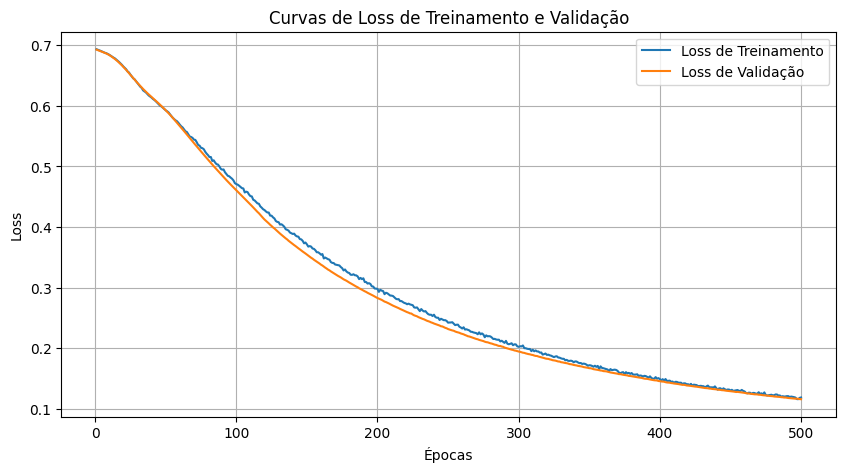

Model saved at 'models/UNSW_EA_1.pth'

--- Training model: UNSW_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6914, Validation Loss: 0.6870
Epoch [2/500], Train Loss: 0.6808, Validation Loss: 0.6633
Epoch [3/500], Train Loss: 0.6514, Validation Loss: 0.6330
Epoch [4/500], Train Loss: 0.6388, Validation Loss: 0.6220
Epoch [5/500], Train Loss: 0.6281, Validation Loss: 0.6149
Epoch [6/500], Train Loss: 0.6228, Validation Loss: 0.6086
Epoch [7/500], Train Loss: 0.6177, Validation Loss: 0.6068
Epoch [8/500], Train Loss: 0.6119, Validation Loss: 0.6046
Epoch [9/500], Train Loss: 0.6049, Validation Loss: 0.5946
Epoch [10/500], Train Loss: 0.6038, Validation Loss: 0.5892
Epoch [11/500], Train Loss: 0.5996, Validation Loss: 0.5950
Epoch [12/500], Train Loss: 0.5945, Validation Loss: 0.5961
Epoch [13/500], Train Loss: 0.5913, Validation Loss: 0.5814
Epoch [14/500], Train Loss: 0.5879, Validation Loss: 0.5865
Epoch [15/500], Train Loss: 0.5805, Validation Loss: 0.5631
Epoch

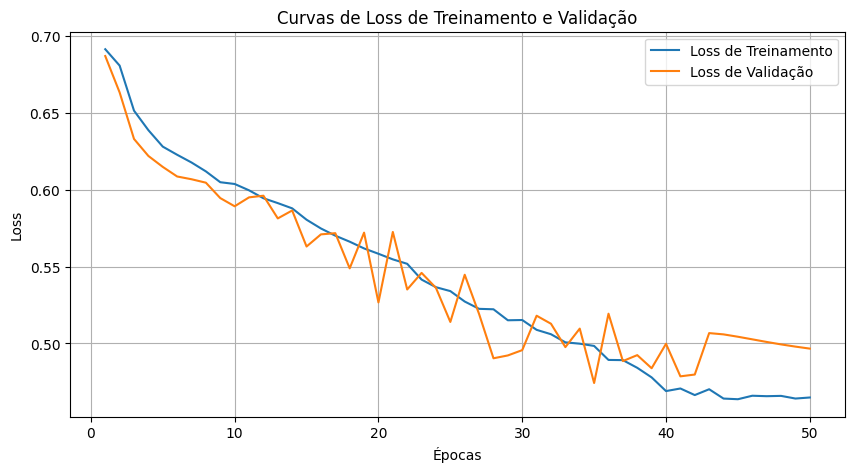

Model saved at 'models/UNSW_EA_2.pth'

--- Training model: UNSW_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.3839, Validation Loss: 1.3790
Epoch [2/500], Train Loss: 1.3723, Validation Loss: 1.3578
Epoch [3/500], Train Loss: 1.3491, Validation Loss: 1.3354
Epoch [4/500], Train Loss: 1.3346, Validation Loss: 1.3280
Epoch [5/500], Train Loss: 1.3274, Validation Loss: 1.3219
Epoch [6/500], Train Loss: 1.3223, Validation Loss: 1.3166
Epoch [7/500], Train Loss: 1.3159, Validation Loss: 1.3103
Epoch [8/500], Train Loss: 1.3128, Validation Loss: 1.3061
Epoch [9/500], Train Loss: 1.3069, Validation Loss: 1.2976
Epoch [10/500], Train Loss: 1.3027, Validation Loss: 1.2914
Epoch [11/500], Train Loss: 1.3038, Validation Loss: 1.2865
Epoch [12/500], Train Loss: 1.2965, Validation Loss: 1.2811
Epoch [13/500], Train Loss: 1.2899, Validation Loss: 1.2755
Epoch [14/500], Train Loss: 1.2870, Validation Loss: 1.2677
Epoch [15/500], Train Loss: 1.2801, Validation Loss: 1.2589
Epoch

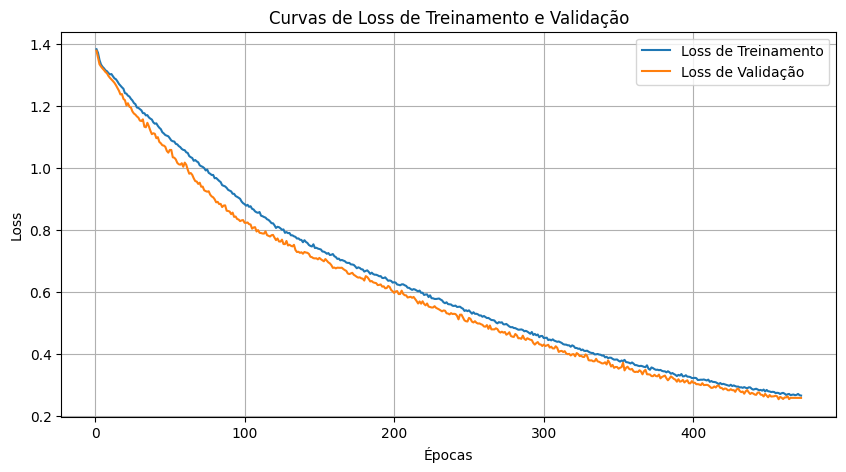

Model saved at 'models/UNSW_EA_3.pth'

--- Training model: BOT_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6952, Validation Loss: 0.6947
Epoch [2/500], Train Loss: 0.6948, Validation Loss: 0.6943
Epoch [3/500], Train Loss: 0.6942, Validation Loss: 0.6940
Epoch [4/500], Train Loss: 0.6938, Validation Loss: 0.6936
Epoch [5/500], Train Loss: 0.6935, Validation Loss: 0.6933
Epoch [6/500], Train Loss: 0.6937, Validation Loss: 0.6930
Epoch [7/500], Train Loss: 0.6927, Validation Loss: 0.6927
Epoch [8/500], Train Loss: 0.6928, Validation Loss: 0.6924
Epoch [9/500], Train Loss: 0.6920, Validation Loss: 0.6921
Epoch [10/500], Train Loss: 0.6922, Validation Loss: 0.6917
Epoch [11/500], Train Loss: 0.6920, Validation Loss: 0.6914
Epoch [12/500], Train Loss: 0.6916, Validation Loss: 0.6911
Epoch [13/500], Train Loss: 0.6913, Validation Loss: 0.6908
Epoch [14/500], Train Loss: 0.6910, Validation Loss: 0.6905
Epoch [15/500], Train Loss: 0.6910, Validation Loss: 0.6902
Epoch 

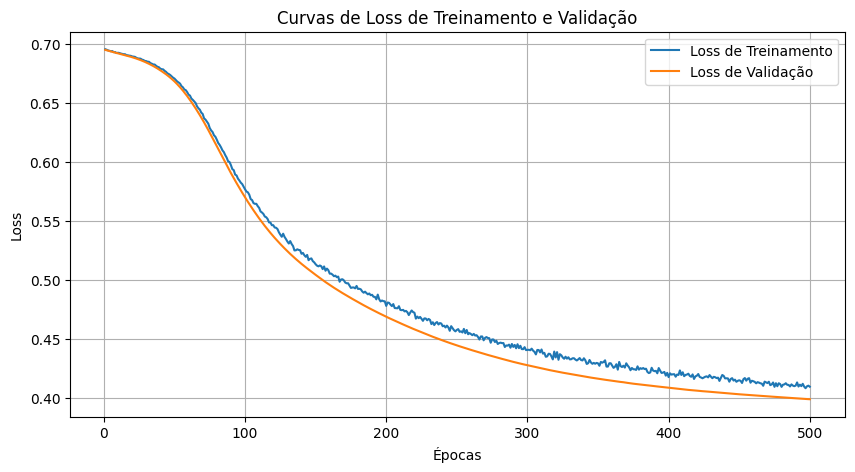

Model saved at 'models/BOT_EA_1.pth'

--- Training model: BOT_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6932, Validation Loss: 0.6925
Epoch [2/500], Train Loss: 0.6924, Validation Loss: 0.6915
Epoch [3/500], Train Loss: 0.6916, Validation Loss: 0.6897
Epoch [4/500], Train Loss: 0.6897, Validation Loss: 0.6863
Epoch [5/500], Train Loss: 0.6865, Validation Loss: 0.6799
Epoch [6/500], Train Loss: 0.6797, Validation Loss: 0.6690
Epoch [7/500], Train Loss: 0.6705, Validation Loss: 0.6524
Epoch [8/500], Train Loss: 0.6572, Validation Loss: 0.6389
Epoch [9/500], Train Loss: 0.6532, Validation Loss: 0.6218
Epoch [10/500], Train Loss: 0.6443, Validation Loss: 0.6038
Epoch [11/500], Train Loss: 0.6325, Validation Loss: 0.5940
Epoch [12/500], Train Loss: 0.6292, Validation Loss: 0.5822
Epoch [13/500], Train Loss: 0.6197, Validation Loss: 0.5744
Epoch [14/500], Train Loss: 0.6176, Validation Loss: 0.5664
Epoch [15/500], Train Loss: 0.6087, Validation Loss: 0.5592
Epoch [

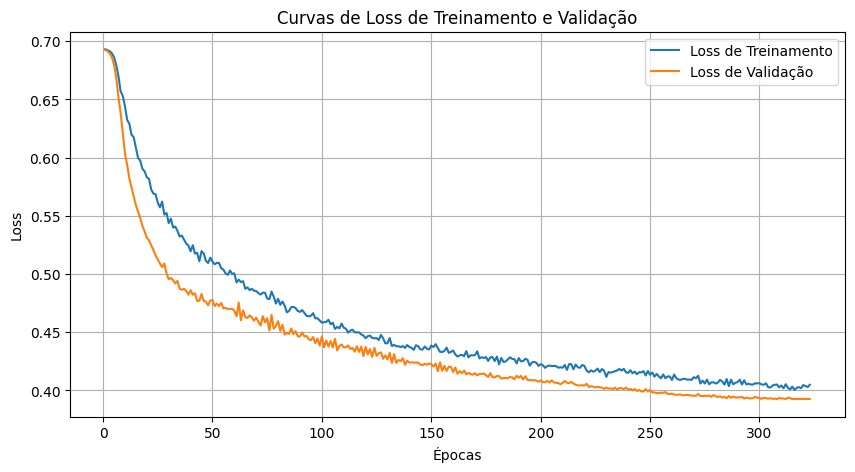

Model saved at 'models/BOT_EA_2.pth'

--- Training model: BOT_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.3878, Validation Loss: 1.3867
Epoch [2/500], Train Loss: 1.3868, Validation Loss: 1.3853
Epoch [3/500], Train Loss: 1.3858, Validation Loss: 1.3833
Epoch [4/500], Train Loss: 1.3839, Validation Loss: 1.3801
Epoch [5/500], Train Loss: 1.3810, Validation Loss: 1.3747
Epoch [6/500], Train Loss: 1.3754, Validation Loss: 1.3662
Epoch [7/500], Train Loss: 1.3683, Validation Loss: 1.3539
Epoch [8/500], Train Loss: 1.3599, Validation Loss: 1.3356
Epoch [9/500], Train Loss: 1.3492, Validation Loss: 1.3161
Epoch [10/500], Train Loss: 1.3390, Validation Loss: 1.2956
Epoch [11/500], Train Loss: 1.3243, Validation Loss: 1.2855
Epoch [12/500], Train Loss: 1.3209, Validation Loss: 1.2646
Epoch [13/500], Train Loss: 1.3120, Validation Loss: 1.2559
Epoch [14/500], Train Loss: 1.3095, Validation Loss: 1.2478
Epoch [15/500], Train Loss: 1.3015, Validation Loss: 1.2477
Epoch [

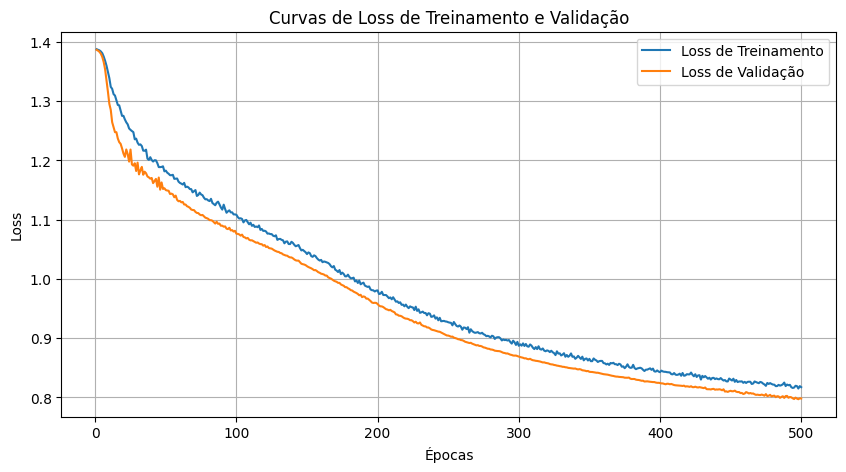

Model saved at 'models/BOT_EA_3.pth'

--- Training model: CIC_EA - Weight Exit 1: 1; Weight Exit 2: 0
Epoch [1/500], Train Loss: 0.6913, Validation Loss: 0.6906
Epoch [2/500], Train Loss: 0.6900, Validation Loss: 0.6892
Epoch [3/500], Train Loss: 0.6887, Validation Loss: 0.6877
Epoch [4/500], Train Loss: 0.6872, Validation Loss: 0.6860
Epoch [5/500], Train Loss: 0.6854, Validation Loss: 0.6842
Epoch [6/500], Train Loss: 0.6836, Validation Loss: 0.6821
Epoch [7/500], Train Loss: 0.6816, Validation Loss: 0.6799
Epoch [8/500], Train Loss: 0.6791, Validation Loss: 0.6774
Epoch [9/500], Train Loss: 0.6766, Validation Loss: 0.6746
Epoch [10/500], Train Loss: 0.6736, Validation Loss: 0.6713
Epoch [11/500], Train Loss: 0.6699, Validation Loss: 0.6675
Epoch [12/500], Train Loss: 0.6661, Validation Loss: 0.6633
Epoch [13/500], Train Loss: 0.6618, Validation Loss: 0.6586
Epoch [14/500], Train Loss: 0.6570, Validation Loss: 0.6535
Epoch [15/500], Train Loss: 0.6517, Validation Loss: 0.6480
Epoch [

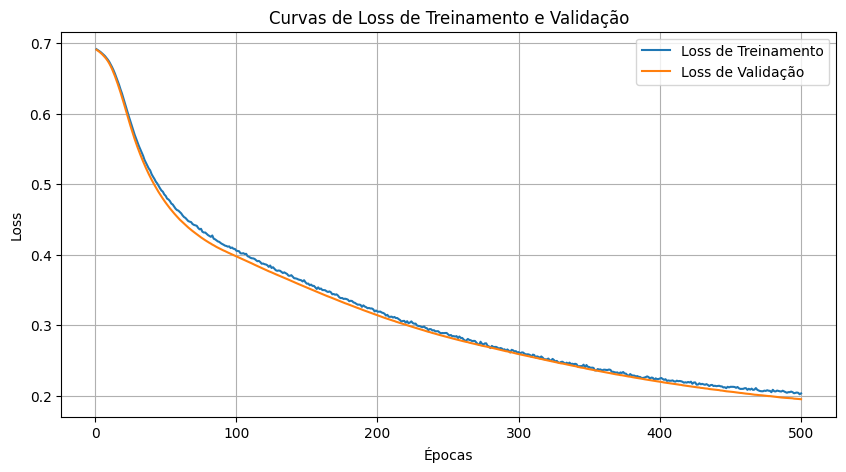

Model saved at 'models/CIC_EA_1.pth'

--- Training model: CIC_EA - Weight Exit 1: 0; Weight Exit 2: 1
Epoch [1/500], Train Loss: 0.6918, Validation Loss: 0.6885
Epoch [2/500], Train Loss: 0.6797, Validation Loss: 0.6603
Epoch [3/500], Train Loss: 0.6584, Validation Loss: 0.6334
Epoch [4/500], Train Loss: 0.6423, Validation Loss: 0.6117
Epoch [5/500], Train Loss: 0.6229, Validation Loss: 0.5978
Epoch [6/500], Train Loss: 0.6110, Validation Loss: 0.5806
Epoch [7/500], Train Loss: 0.5952, Validation Loss: 0.5569
Epoch [8/500], Train Loss: 0.5853, Validation Loss: 0.5448
Epoch [9/500], Train Loss: 0.5683, Validation Loss: 0.5296
Epoch [10/500], Train Loss: 0.5593, Validation Loss: 0.5151
Epoch [11/500], Train Loss: 0.5465, Validation Loss: 0.5006
Epoch [12/500], Train Loss: 0.5383, Validation Loss: 0.4906
Epoch [13/500], Train Loss: 0.5299, Validation Loss: 0.4845
Epoch [14/500], Train Loss: 0.5177, Validation Loss: 0.4690
Epoch [15/500], Train Loss: 0.5117, Validation Loss: 0.4788
Epoch [

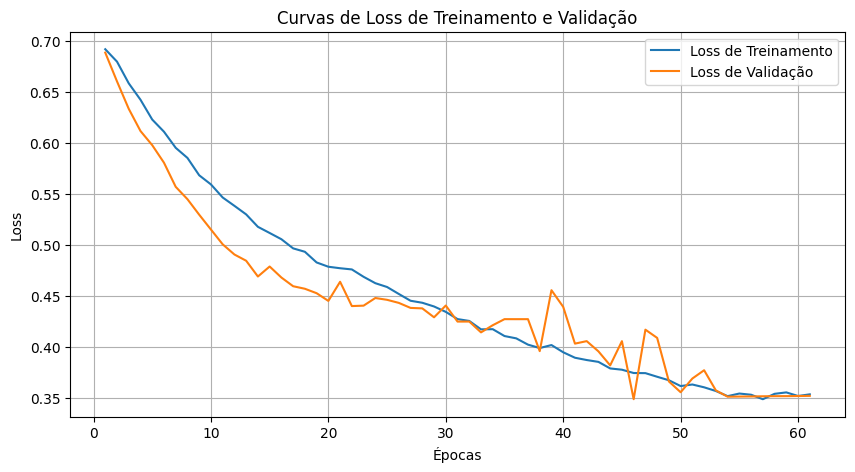

Model saved at 'models/CIC_EA_2.pth'

--- Training model: CIC_EA - Weight Exit 1: 1; Weight Exit 2: 1
Epoch [1/500], Train Loss: 1.3866, Validation Loss: 1.3811
Epoch [2/500], Train Loss: 1.3728, Validation Loss: 1.3523
Epoch [3/500], Train Loss: 1.3474, Validation Loss: 1.3183
Epoch [4/500], Train Loss: 1.3228, Validation Loss: 1.2785
Epoch [5/500], Train Loss: 1.3039, Validation Loss: 1.2511
Epoch [6/500], Train Loss: 1.2897, Validation Loss: 1.2426
Epoch [7/500], Train Loss: 1.2730, Validation Loss: 1.2313
Epoch [8/500], Train Loss: 1.2612, Validation Loss: 1.2136
Epoch [9/500], Train Loss: 1.2463, Validation Loss: 1.2066
Epoch [10/500], Train Loss: 1.2384, Validation Loss: 1.1905
Epoch [11/500], Train Loss: 1.2253, Validation Loss: 1.1846
Epoch [12/500], Train Loss: 1.2174, Validation Loss: 1.1714
Epoch [13/500], Train Loss: 1.2069, Validation Loss: 1.1685
Epoch [14/500], Train Loss: 1.1974, Validation Loss: 1.1584
Epoch [15/500], Train Loss: 1.1962, Validation Loss: 1.1503
Epoch [

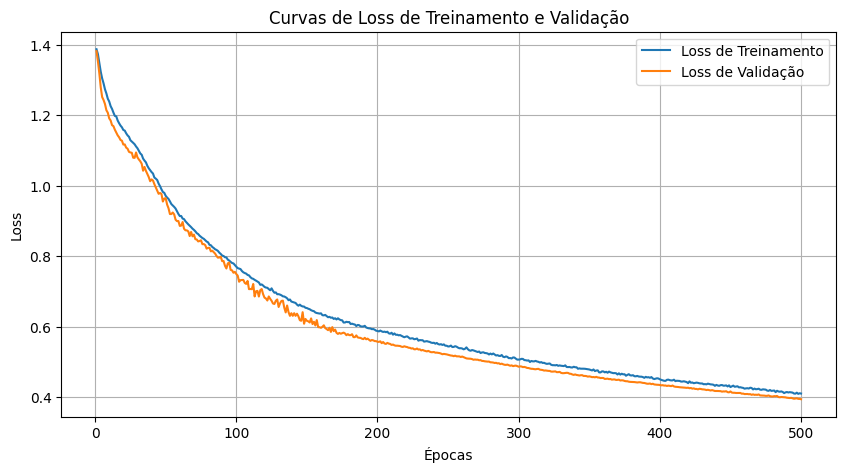

Model saved at 'models/CIC_EA_3.pth'



In [29]:
epochs = 500

for model_id in range(len(model_names)):
    for test in test_ids:
        model = IDSBranchyNet()
        
        if test == 1:
            weight1 = 1
            weight2 = 0
        elif test == 2:
            weight1 = 0
            weight2 = 1
        elif test == 3:
            weight1 = 1
            weight2 = 1
        
            
        print(f"--- Training model: {model_names[model_id]} - Weight Exit 1: {weight1}; Weight Exit 2: {weight2}")
        
        train_losses, val_losses = train_model(model, train_loaders[model_id], val_loaders[model_id], epochs, weight1, weight2, lr=0.0001, device=device, modelname=model_names[model_id])

        torch.save(model.state_dict(), f'models/{model_names[model_id]}_{test}.pth')
        print(f"Model saved at 'models/{model_names[model_id]}_{test}.pth'\n")
        

0.9831
--- Model: UNSW_EA | Loader: UNSW_EA | TestID: 1 ---
Model from: 'models/UNSW_EA_1.pth' carregado


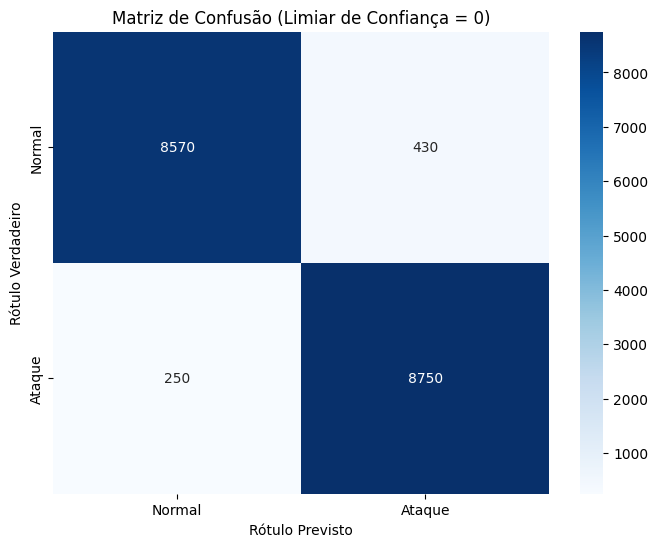

True Positives (TP): 8750
True Negatives (TN): 8570
False Positives (FP): 430
False Negatives (FN): 250

F1 Score: 0.9626
True Positive Rate (TPR) / Recall: 0.9722
True Negative Rate (TNR) / Specificity: 0.9522
--------------------
Threshold: 0.0000
  Accuracy: 0.9622
  Total Inference Time: 1.2987 s
  Early Exit Rate: 1.0000 (18000/18000)
--------------------


--- Model: UNSW_EA | Loader: UNSW_EA | TestID: 2 ---
Model from: 'models/UNSW_EA_2.pth' carregado


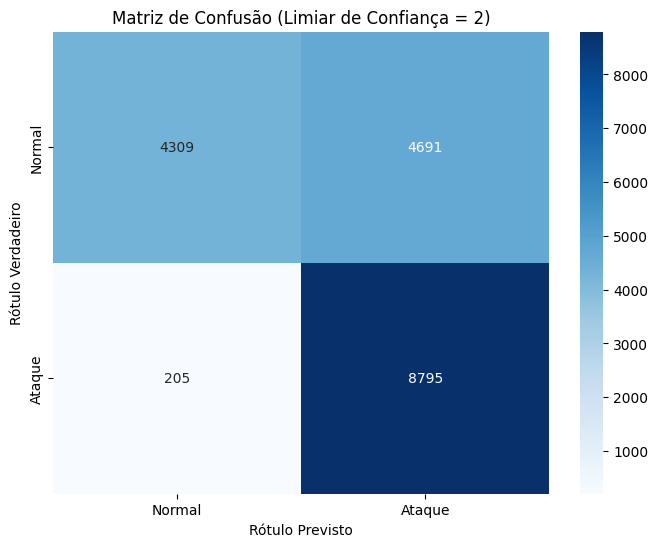

True Positives (TP): 8795
True Negatives (TN): 4309
False Positives (FP): 4691
False Negatives (FN): 205

F1 Score: 0.7823
True Positive Rate (TPR) / Recall: 0.9772
True Negative Rate (TNR) / Specificity: 0.4788
--------------------
Threshold: 2.0000
  Accuracy: 0.7280
  Total Inference Time: 1.9102 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: UNSW_EA | Loader: UNSW_EA | TestID: 3 ---
Model from: 'models/UNSW_EA_3.pth' carregado


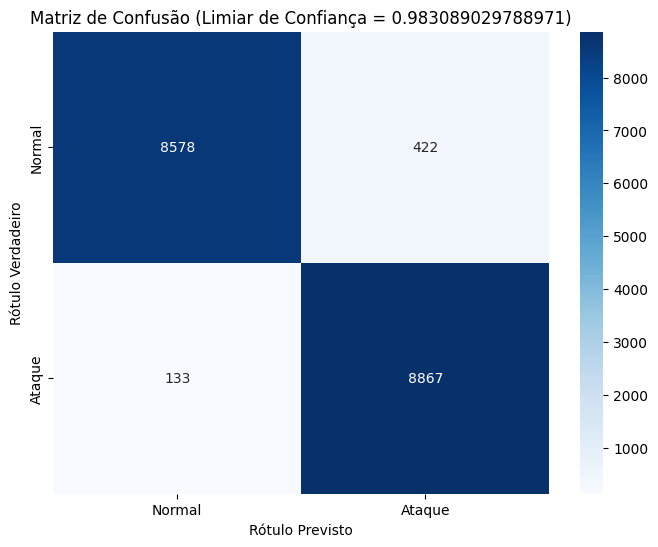

True Positives (TP): 8867
True Negatives (TN): 8578
False Positives (FP): 422
False Negatives (FN): 133

F1 Score: 0.9697
True Positive Rate (TPR) / Recall: 0.9852
True Negative Rate (TNR) / Specificity: 0.9531
--------------------
Threshold: 0.9831
  Accuracy: 0.9692
  Total Inference Time: 1.7926 s
  Early Exit Rate: 0.2234 (4022/18000)
--------------------


--- Model: UNSW_EA | Loader: BOT_EA | TestID: 1 ---
Model from: 'models/UNSW_EA_1.pth' carregado


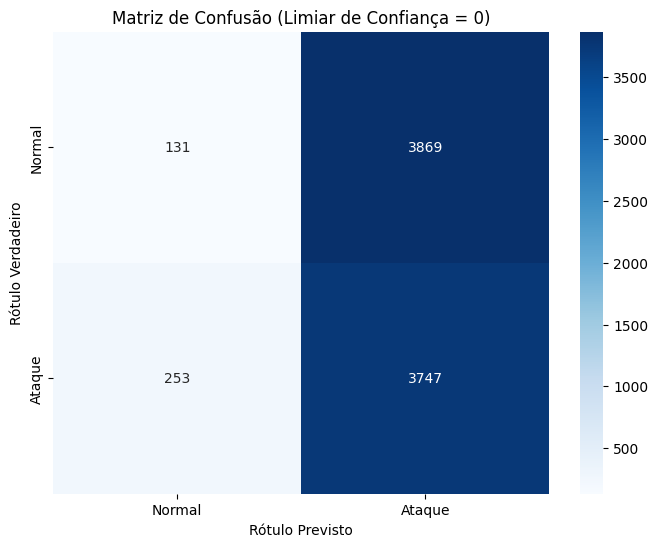

True Positives (TP): 3747
True Negatives (TN): 131
False Positives (FP): 3869
False Negatives (FN): 253

F1 Score: 0.6451
True Positive Rate (TPR) / Recall: 0.9367
True Negative Rate (TNR) / Specificity: 0.0328
--------------------
Threshold: 0.0000
  Accuracy: 0.4848
  Total Inference Time: 1.2833 s
  Early Exit Rate: 1.0000 (8000/8000)
--------------------


--- Model: UNSW_EA | Loader: BOT_EA | TestID: 2 ---
Model from: 'models/UNSW_EA_2.pth' carregado


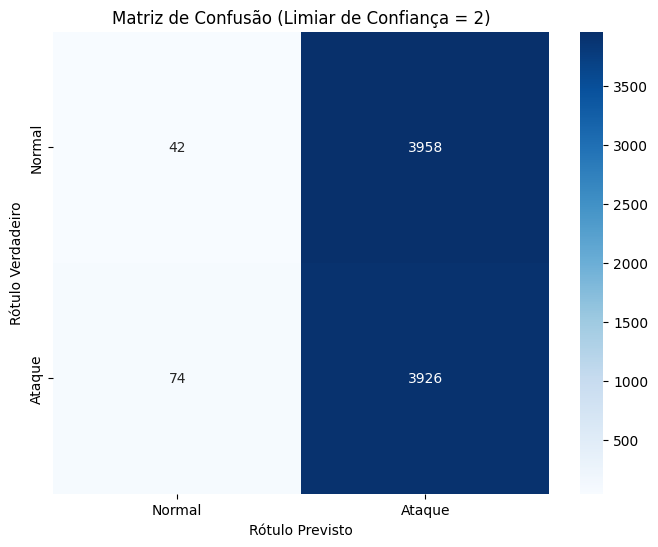

True Positives (TP): 3926
True Negatives (TN): 42
False Positives (FP): 3958
False Negatives (FN): 74

F1 Score: 0.6607
True Positive Rate (TPR) / Recall: 0.9815
True Negative Rate (TNR) / Specificity: 0.0105
--------------------
Threshold: 2.0000
  Accuracy: 0.4960
  Total Inference Time: 1.5928 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: UNSW_EA | Loader: BOT_EA | TestID: 3 ---
Model from: 'models/UNSW_EA_3.pth' carregado


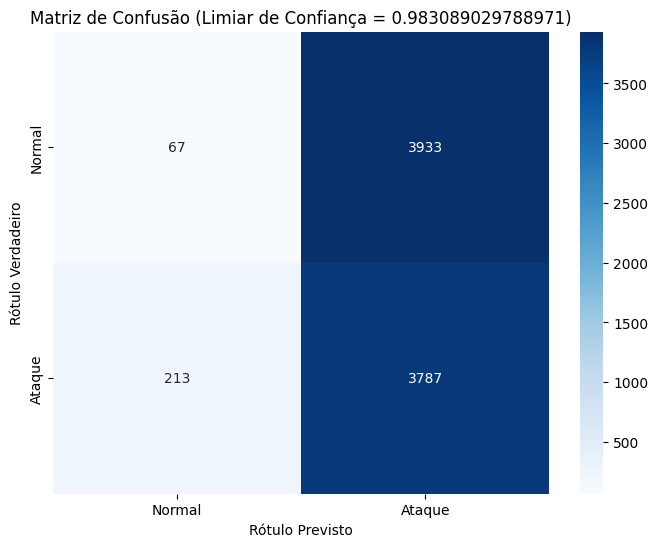

True Positives (TP): 3787
True Negatives (TN): 67
False Positives (FP): 3933
False Negatives (FN): 213

F1 Score: 0.6462
True Positive Rate (TPR) / Recall: 0.9467
True Negative Rate (TNR) / Specificity: 0.0168
--------------------
Threshold: 0.9831
  Accuracy: 0.4818
  Total Inference Time: 1.6912 s
  Early Exit Rate: 0.2186 (1749/8000)
--------------------


--- Model: UNSW_EA | Loader: CIC_EA | TestID: 1 ---
Model from: 'models/UNSW_EA_1.pth' carregado


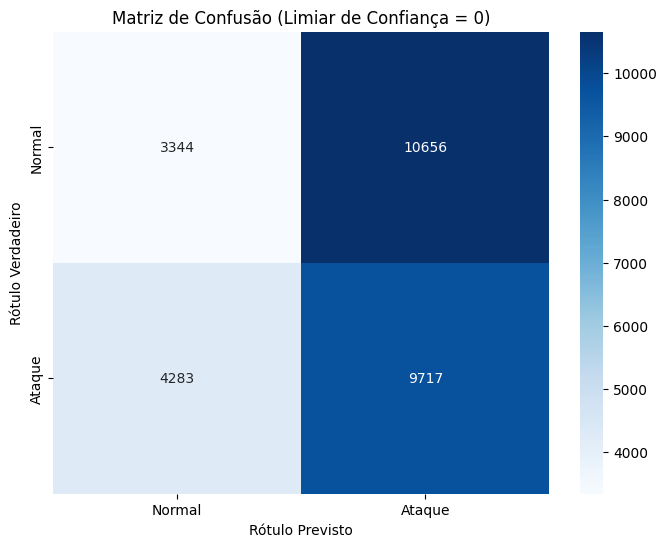

True Positives (TP): 9717
True Negatives (TN): 3344
False Positives (FP): 10656
False Negatives (FN): 4283

F1 Score: 0.5654
True Positive Rate (TPR) / Recall: 0.6941
True Negative Rate (TNR) / Specificity: 0.2389
--------------------
Threshold: 0.0000
  Accuracy: 0.4665
  Total Inference Time: 1.3332 s
  Early Exit Rate: 1.0000 (28000/28000)
--------------------


--- Model: UNSW_EA | Loader: CIC_EA | TestID: 2 ---
Model from: 'models/UNSW_EA_2.pth' carregado


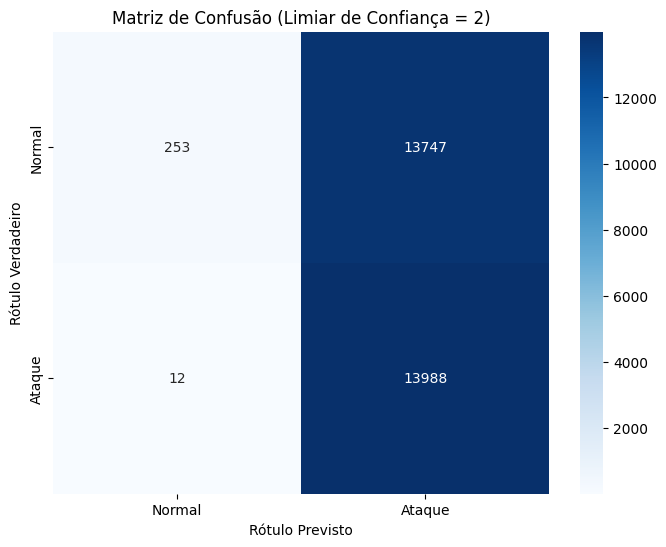

True Positives (TP): 13988
True Negatives (TN): 253
False Positives (FP): 13747
False Negatives (FN): 12

F1 Score: 0.6703
True Positive Rate (TPR) / Recall: 0.9991
True Negative Rate (TNR) / Specificity: 0.0181
--------------------
Threshold: 2.0000
  Accuracy: 0.5086
  Total Inference Time: 2.2384 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: UNSW_EA | Loader: CIC_EA | TestID: 3 ---
Model from: 'models/UNSW_EA_3.pth' carregado


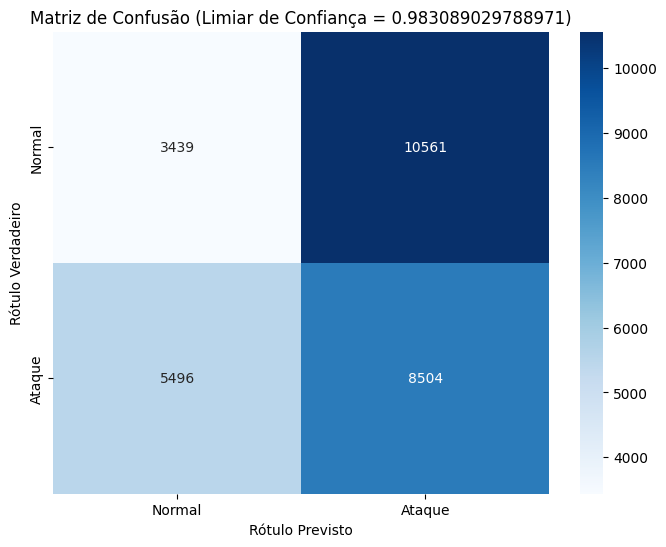

True Positives (TP): 8504
True Negatives (TN): 3439
False Positives (FP): 10561
False Negatives (FN): 5496

F1 Score: 0.5144
True Positive Rate (TPR) / Recall: 0.6074
True Negative Rate (TNR) / Specificity: 0.2456
--------------------
Threshold: 0.9831
  Accuracy: 0.4265
  Total Inference Time: 2.3080 s
  Early Exit Rate: 0.1222 (3423/28000)
--------------------


--- Model: BOT_EA | Loader: UNSW_EA | TestID: 1 ---
Model from: 'models/BOT_EA_1.pth' carregado


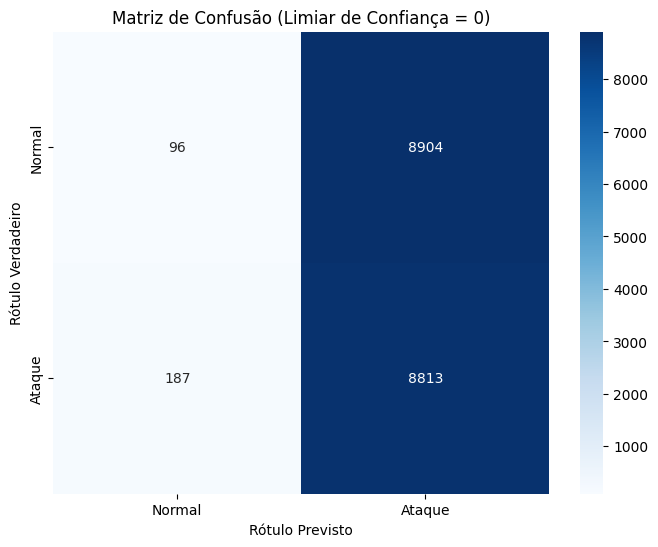

True Positives (TP): 8813
True Negatives (TN): 96
False Positives (FP): 8904
False Negatives (FN): 187

F1 Score: 0.6597
True Positive Rate (TPR) / Recall: 0.9792
True Negative Rate (TNR) / Specificity: 0.0107
--------------------
Threshold: 0.0000
  Accuracy: 0.4949
  Total Inference Time: 1.3750 s
  Early Exit Rate: 1.0000 (18000/18000)
--------------------


--- Model: BOT_EA | Loader: UNSW_EA | TestID: 2 ---
Model from: 'models/BOT_EA_2.pth' carregado


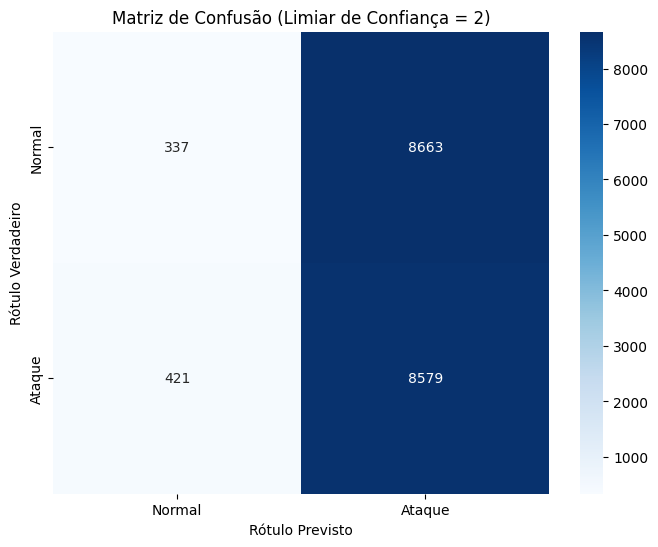

True Positives (TP): 8579
True Negatives (TN): 337
False Positives (FP): 8663
False Negatives (FN): 421

F1 Score: 0.6538
True Positive Rate (TPR) / Recall: 0.9532
True Negative Rate (TNR) / Specificity: 0.0374
--------------------
Threshold: 2.0000
  Accuracy: 0.4953
  Total Inference Time: 1.8704 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: BOT_EA | Loader: UNSW_EA | TestID: 3 ---
Model from: 'models/BOT_EA_3.pth' carregado


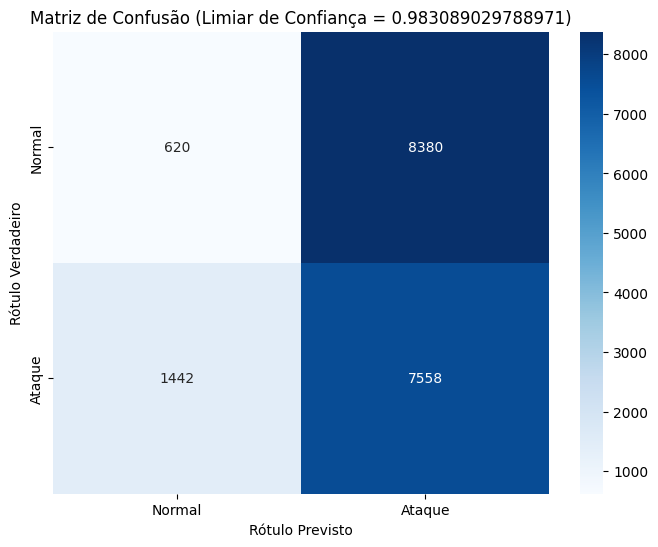

True Positives (TP): 7558
True Negatives (TN): 620
False Positives (FP): 8380
False Negatives (FN): 1442

F1 Score: 0.6061
True Positive Rate (TPR) / Recall: 0.8398
True Negative Rate (TNR) / Specificity: 0.0689
--------------------
Threshold: 0.9831
  Accuracy: 0.4543
  Total Inference Time: 1.5997 s
  Early Exit Rate: 0.3306 (5951/18000)
--------------------


--- Model: BOT_EA | Loader: BOT_EA | TestID: 1 ---
Model from: 'models/BOT_EA_1.pth' carregado


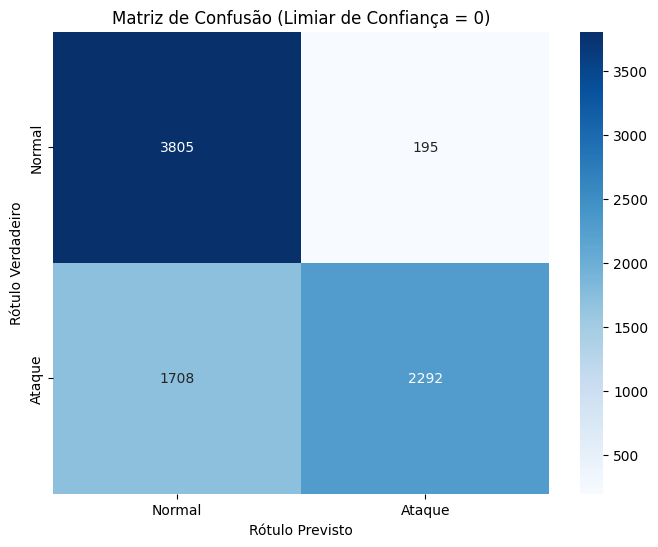

True Positives (TP): 2292
True Negatives (TN): 3805
False Positives (FP): 195
False Negatives (FN): 1708

F1 Score: 0.7066
True Positive Rate (TPR) / Recall: 0.5730
True Negative Rate (TNR) / Specificity: 0.9513
--------------------
Threshold: 0.0000
  Accuracy: 0.7621
  Total Inference Time: 1.2670 s
  Early Exit Rate: 1.0000 (8000/8000)
--------------------


--- Model: BOT_EA | Loader: BOT_EA | TestID: 2 ---
Model from: 'models/BOT_EA_2.pth' carregado


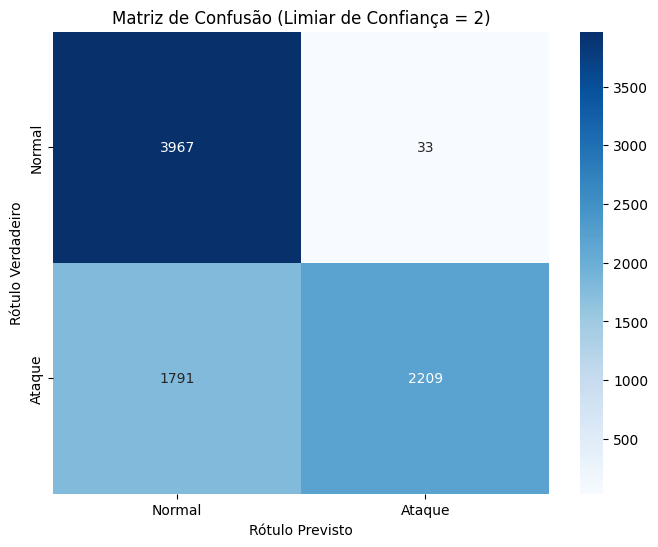

True Positives (TP): 2209
True Negatives (TN): 3967
False Positives (FP): 33
False Negatives (FN): 1791

F1 Score: 0.7078
True Positive Rate (TPR) / Recall: 0.5523
True Negative Rate (TNR) / Specificity: 0.9918
--------------------
Threshold: 2.0000
  Accuracy: 0.7720
  Total Inference Time: 1.6878 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: BOT_EA | Loader: BOT_EA | TestID: 3 ---
Model from: 'models/BOT_EA_3.pth' carregado


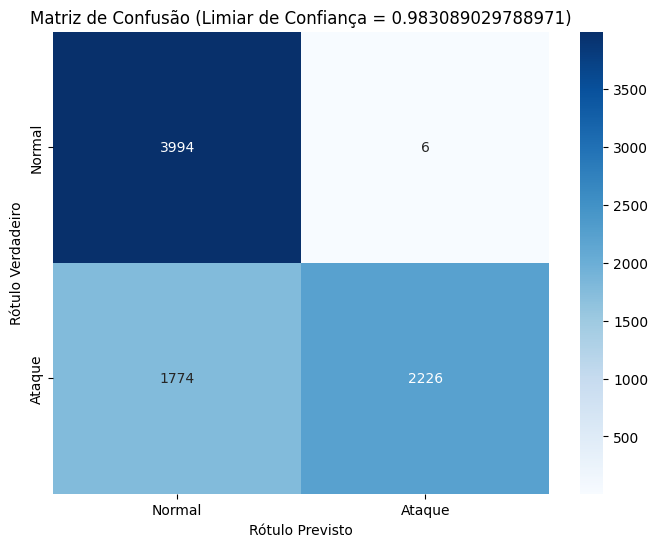

True Positives (TP): 2226
True Negatives (TN): 3994
False Positives (FP): 6
False Negatives (FN): 1774

F1 Score: 0.7144
True Positive Rate (TPR) / Recall: 0.5565
True Negative Rate (TNR) / Specificity: 0.9985
--------------------
Threshold: 0.9831
  Accuracy: 0.7775
  Total Inference Time: 1.7352 s
  Early Exit Rate: 0.1491 (1193/8000)
--------------------


--- Model: BOT_EA | Loader: CIC_EA | TestID: 1 ---
Model from: 'models/BOT_EA_1.pth' carregado


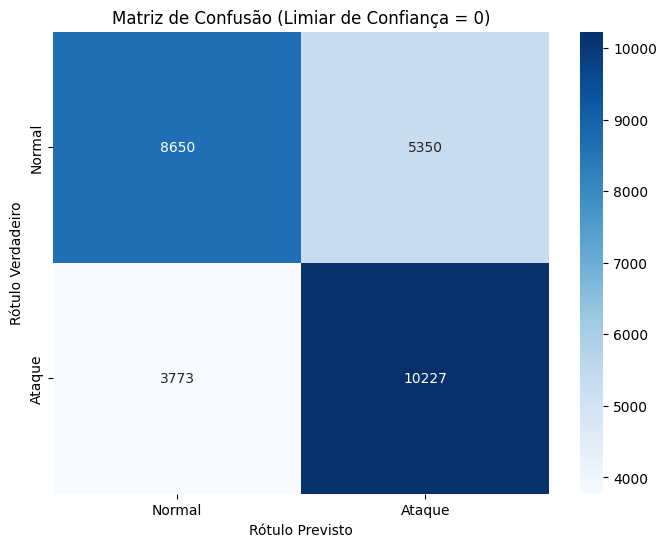

True Positives (TP): 10227
True Negatives (TN): 8650
False Positives (FP): 5350
False Negatives (FN): 3773

F1 Score: 0.6916
True Positive Rate (TPR) / Recall: 0.7305
True Negative Rate (TNR) / Specificity: 0.6179
--------------------
Threshold: 0.0000
  Accuracy: 0.6742
  Total Inference Time: 1.6265 s
  Early Exit Rate: 1.0000 (28000/28000)
--------------------


--- Model: BOT_EA | Loader: CIC_EA | TestID: 2 ---
Model from: 'models/BOT_EA_2.pth' carregado


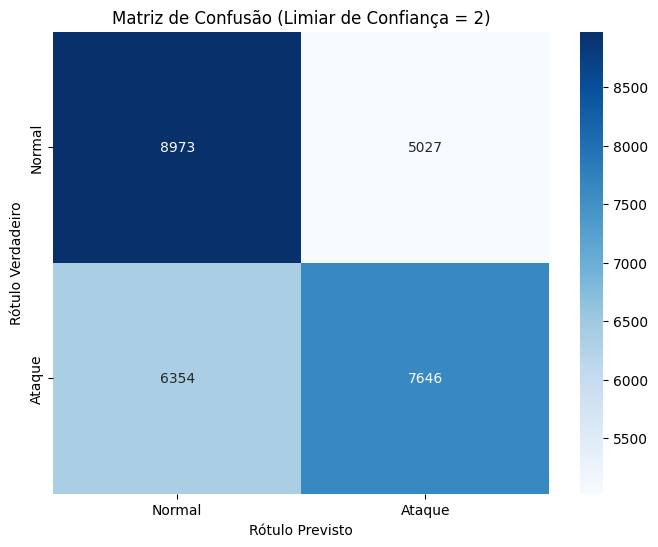

True Positives (TP): 7646
True Negatives (TN): 8973
False Positives (FP): 5027
False Negatives (FN): 6354

F1 Score: 0.5733
True Positive Rate (TPR) / Recall: 0.5461
True Negative Rate (TNR) / Specificity: 0.6409
--------------------
Threshold: 2.0000
  Accuracy: 0.5935
  Total Inference Time: 2.4011 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: BOT_EA | Loader: CIC_EA | TestID: 3 ---
Model from: 'models/BOT_EA_3.pth' carregado


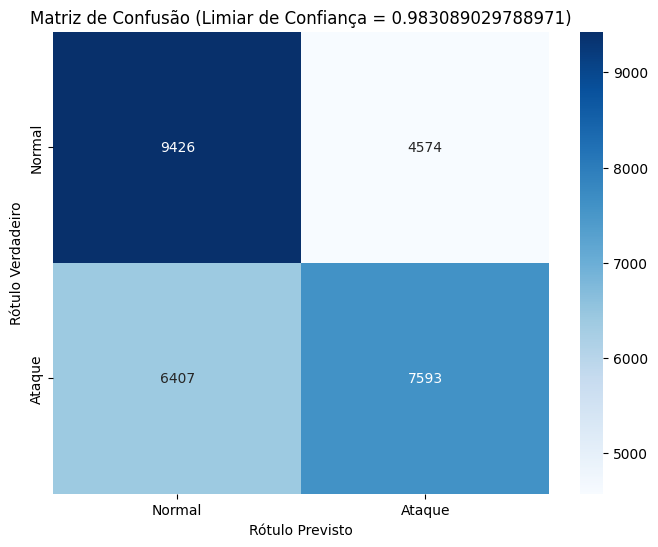

True Positives (TP): 7593
True Negatives (TN): 9426
False Positives (FP): 4574
False Negatives (FN): 6407

F1 Score: 0.5803
True Positive Rate (TPR) / Recall: 0.5424
True Negative Rate (TNR) / Specificity: 0.6733
--------------------
Threshold: 0.9831
  Accuracy: 0.6078
  Total Inference Time: 2.0655 s
  Early Exit Rate: 0.1917 (5368/28000)
--------------------


--- Model: CIC_EA | Loader: UNSW_EA | TestID: 1 ---
Model from: 'models/CIC_EA_1.pth' carregado


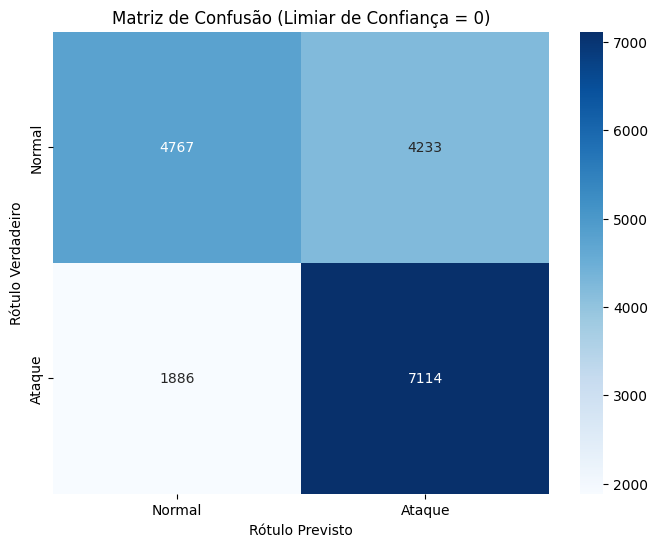

True Positives (TP): 7114
True Negatives (TN): 4767
False Positives (FP): 4233
False Negatives (FN): 1886

F1 Score: 0.6993
True Positive Rate (TPR) / Recall: 0.7904
True Negative Rate (TNR) / Specificity: 0.5297
--------------------
Threshold: 0.0000
  Accuracy: 0.6601
  Total Inference Time: 1.3075 s
  Early Exit Rate: 1.0000 (18000/18000)
--------------------


--- Model: CIC_EA | Loader: UNSW_EA | TestID: 2 ---
Model from: 'models/CIC_EA_2.pth' carregado


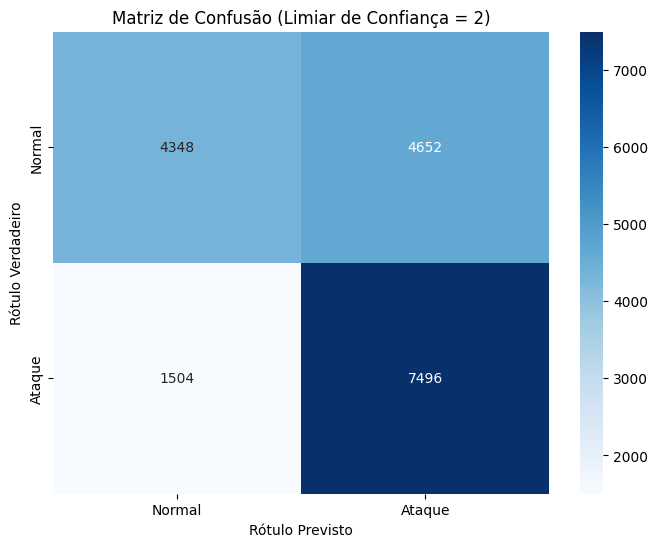

True Positives (TP): 7496
True Negatives (TN): 4348
False Positives (FP): 4652
False Negatives (FN): 1504

F1 Score: 0.7089
True Positive Rate (TPR) / Recall: 0.8329
True Negative Rate (TNR) / Specificity: 0.4831
--------------------
Threshold: 2.0000
  Accuracy: 0.6580
  Total Inference Time: 2.1033 s
  Early Exit Rate: 0.0000 (0/18000)
--------------------


--- Model: CIC_EA | Loader: UNSW_EA | TestID: 3 ---
Model from: 'models/CIC_EA_3.pth' carregado


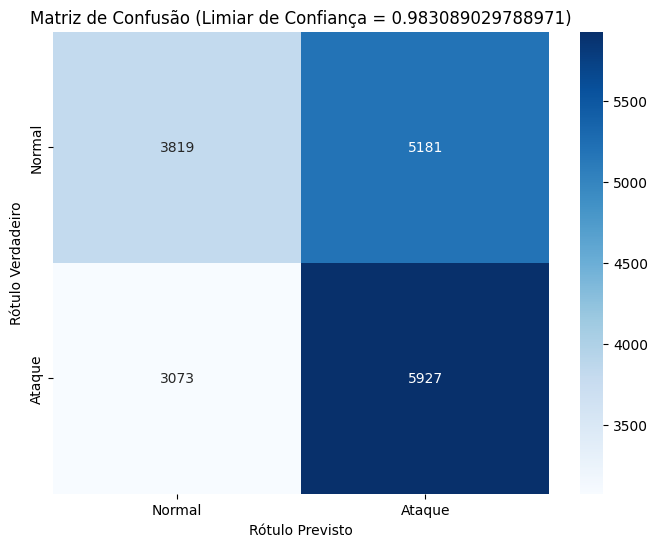

True Positives (TP): 5927
True Negatives (TN): 3819
False Positives (FP): 5181
False Negatives (FN): 3073

F1 Score: 0.5895
True Positive Rate (TPR) / Recall: 0.6586
True Negative Rate (TNR) / Specificity: 0.4243
--------------------
Threshold: 0.9831
  Accuracy: 0.5414
  Total Inference Time: 1.9121 s
  Early Exit Rate: 0.2036 (3664/18000)
--------------------


--- Model: CIC_EA | Loader: BOT_EA | TestID: 1 ---
Model from: 'models/CIC_EA_1.pth' carregado


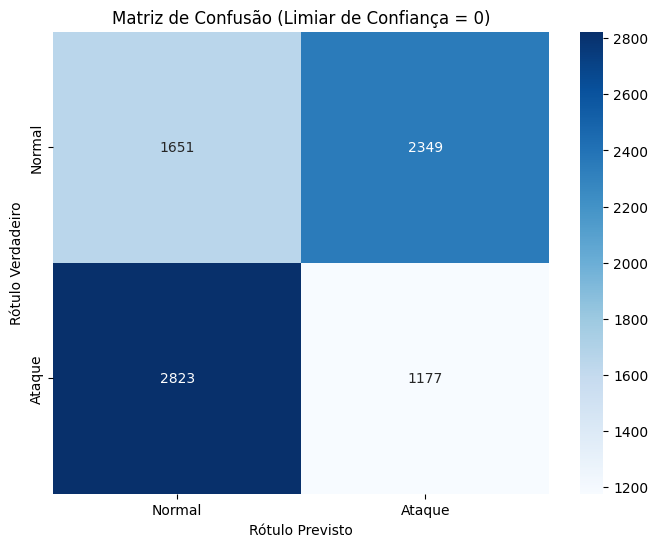

True Positives (TP): 1177
True Negatives (TN): 1651
False Positives (FP): 2349
False Negatives (FN): 2823

F1 Score: 0.3128
True Positive Rate (TPR) / Recall: 0.2943
True Negative Rate (TNR) / Specificity: 0.4128
--------------------
Threshold: 0.0000
  Accuracy: 0.3535
  Total Inference Time: 1.8189 s
  Early Exit Rate: 1.0000 (8000/8000)
--------------------


--- Model: CIC_EA | Loader: BOT_EA | TestID: 2 ---
Model from: 'models/CIC_EA_2.pth' carregado


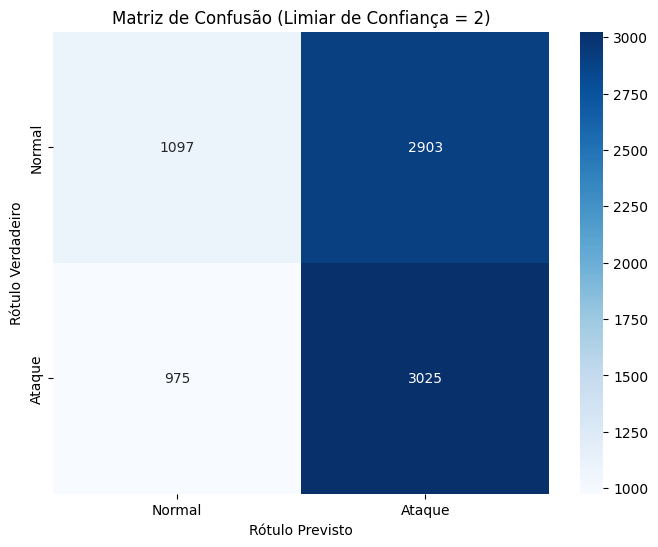

True Positives (TP): 3025
True Negatives (TN): 1097
False Positives (FP): 2903
False Negatives (FN): 975

F1 Score: 0.6094
True Positive Rate (TPR) / Recall: 0.7562
True Negative Rate (TNR) / Specificity: 0.2742
--------------------
Threshold: 2.0000
  Accuracy: 0.5152
  Total Inference Time: 1.5081 s
  Early Exit Rate: 0.0000 (0/8000)
--------------------


--- Model: CIC_EA | Loader: BOT_EA | TestID: 3 ---
Model from: 'models/CIC_EA_3.pth' carregado


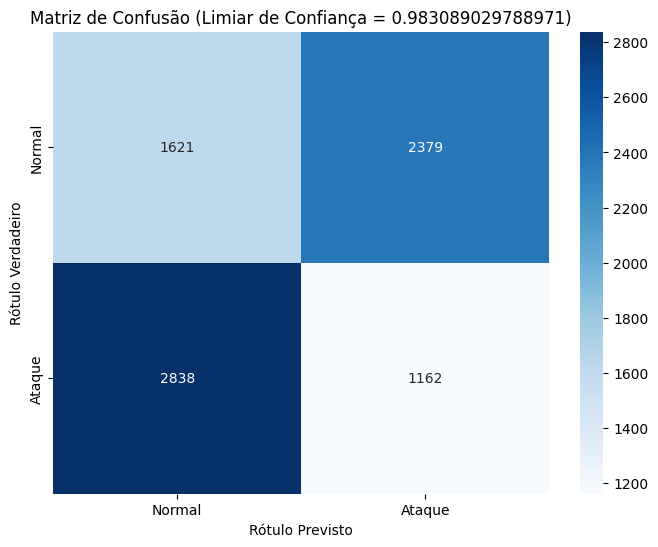

True Positives (TP): 1162
True Negatives (TN): 1621
False Positives (FP): 2379
False Negatives (FN): 2838

F1 Score: 0.3082
True Positive Rate (TPR) / Recall: 0.2905
True Negative Rate (TNR) / Specificity: 0.4052
--------------------
Threshold: 0.9831
  Accuracy: 0.3479
  Total Inference Time: 1.5273 s
  Early Exit Rate: 0.0465 (372/8000)
--------------------


--- Model: CIC_EA | Loader: CIC_EA | TestID: 1 ---
Model from: 'models/CIC_EA_1.pth' carregado


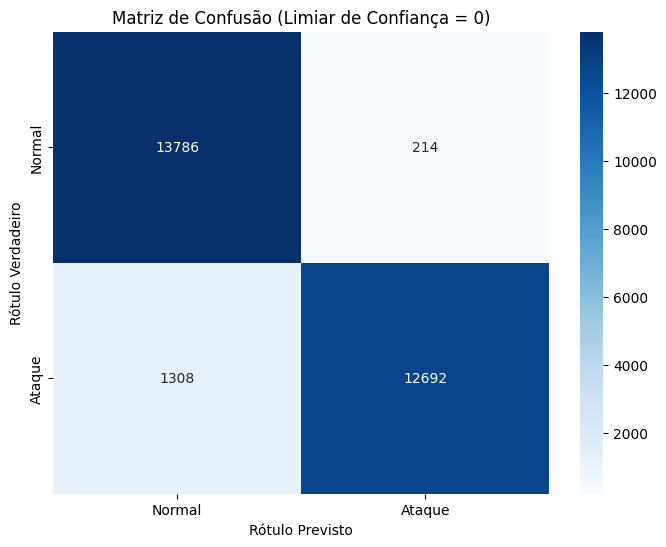

True Positives (TP): 12692
True Negatives (TN): 13786
False Positives (FP): 214
False Negatives (FN): 1308

F1 Score: 0.9434
True Positive Rate (TPR) / Recall: 0.9066
True Negative Rate (TNR) / Specificity: 0.9847
--------------------
Threshold: 0.0000
  Accuracy: 0.9456
  Total Inference Time: 1.5753 s
  Early Exit Rate: 1.0000 (28000/28000)
--------------------


--- Model: CIC_EA | Loader: CIC_EA | TestID: 2 ---
Model from: 'models/CIC_EA_2.pth' carregado


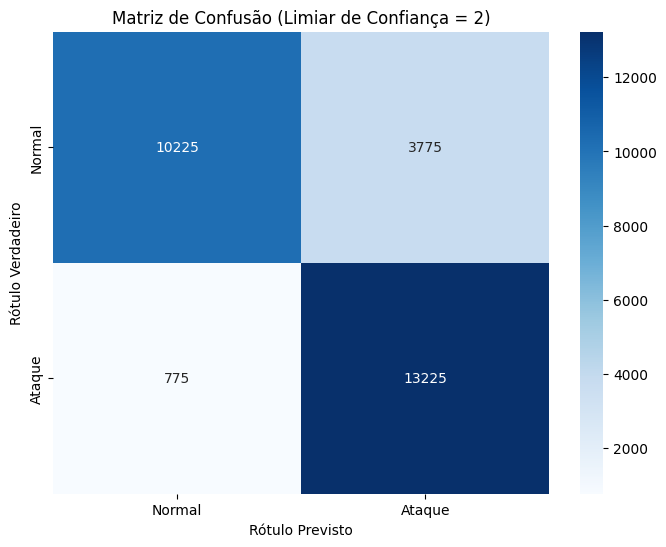

True Positives (TP): 13225
True Negatives (TN): 10225
False Positives (FP): 3775
False Negatives (FN): 775

F1 Score: 0.8532
True Positive Rate (TPR) / Recall: 0.9446
True Negative Rate (TNR) / Specificity: 0.7304
--------------------
Threshold: 2.0000
  Accuracy: 0.8375
  Total Inference Time: 2.2432 s
  Early Exit Rate: 0.0000 (0/28000)
--------------------


--- Model: CIC_EA | Loader: CIC_EA | TestID: 3 ---
Model from: 'models/CIC_EA_3.pth' carregado


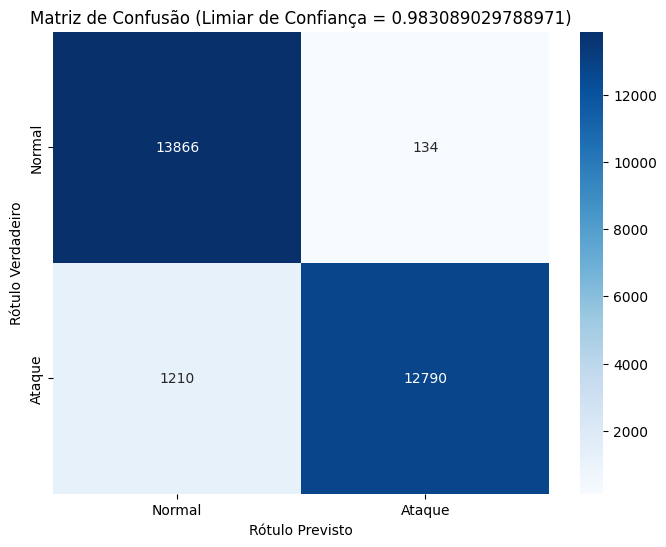

True Positives (TP): 12790
True Negatives (TN): 13866
False Positives (FP): 134
False Negatives (FN): 1210

F1 Score: 0.9501
True Positive Rate (TPR) / Recall: 0.9136
True Negative Rate (TNR) / Specificity: 0.9904
--------------------
Threshold: 0.9831
  Accuracy: 0.9520
  Total Inference Time: 1.9991 s
  Early Exit Rate: 0.2378 (6658/28000)
--------------------




In [30]:
target_exit_rate = 0.20
percentile_threshold = (1 - target_exit_rate) * 100 
global_confs = []

for model_id in range(len(model_names)):
    model = IDSBranchyNet() 
    model.load_state_dict(torch.load(f'models/{model_names[model_id]}_3.pth'))
    model.to(device)
    model.eval()
    
    for loader in range(len(test_loaders)):
        with torch.no_grad():
            for samples, _ in test_loaders[loader]:
                samples = samples.to(device)
                
                branch_output = model.forward_exit1(samples)
                branch_prob = F.softmax(branch_output, dim=1)
                branch_conf, _ = torch.max(branch_prob, 1)
                
                global_confs.append(branch_conf.cpu().numpy())

global_confs = np.concatenate(global_confs)
fixed_threshold_t3 = np.percentile(global_confs, percentile_threshold)

print(f"{fixed_threshold_t3:.4f}")

for model_id in range(len(model_names)):
    for loader in range(len(test_loaders)):
        for test in test_ids:
    
            print(f"--- Model: {model_names[model_id]} | Loader: {model_names[loader]} | TestID: {test} ---")
    
            model.load_state_dict(torch.load(f'models/{model_names[model_id]}_{test}.pth'))
            model.to(device)
            model.eval()
            print(f"Model from: 'models/{model_names[model_id]}_{test}.pth' carregado")

            if test == 1:
                t=0
            elif test == 2:
                t=2
            elif test == 3:
                t=fixed_threshold_t3
    
            results = evaluate_model(model, test_loaders[loader], confidence_threshold=t, device=device)
            
            print("-" * 20)
            print(f"Threshold: {t:.4f}")
            print(f"  Accuracy: {results['accuracy']:.4f}")
            print(f"  Total Inference Time: {results['total_inference_time_sec']:.4f} s")
            print(f"  Early Exit Rate: {results['exit_rate']:.4f} ({results['exited_early_count']}/{results['total_samples']})")
            print("-" * 20)
            print("\n")